### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
%matplotlib inline

# Project path
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data/')

images_data = pd.read_csv(cwd+"/images_data.csv")
images_data['label'] = images_data['label'].astype(str)

train_data = images_data.loc[images_data['classes']=='train']
test_data = images_data.loc[images_data['classes']=='test']

In [2]:
train_data.head()

,classes,label,full_path,width,height,ratio
12500,train,0,/home/workspace/capstone/MachineLearningProjec...,226,431,0.524362
12501,train,0,/home/workspace/capstone/MachineLearningProjec...,375,499,0.751503
12502,train,1,/home/workspace/capstone/MachineLearningProjec...,375,499,0.751503
12503,train,0,/home/workspace/capstone/MachineLearningProjec...,337,500,0.674000
12504,train,1,/home/workspace/capstone/MachineLearningProjec...,500,277,1.805054


In [3]:
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-z79fp_xu
  Running setup.py bdist_wheel for Keras-Preprocessing ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-07vmsym7/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


In [4]:
from keras_preprocessing.image import ImageDataGenerator

def get_images_generator(image_size):
    img_gen = ImageDataGenerator()
    train_img_generator = img_gen.flow_from_dataframe(
                                    dataframe=train_data,
                                    directory=data_dir+'train',
                                    x_col='full_path',
                                    y_col='label',
                                    target_size=image_size,
                                    class_mode='binary',
                                    batch_size=1,
                                    shuffle=False
                                    )

    test_img_generator = img_gen.flow_from_dataframe(
                                    dataframe=test_data,
                                    directory=data_dir+'test',
                                    x_col='full_path',
                                    target_size=image_size,
                                    class_mode = None,
                                    batch_size=1,
                                    shuffle=False)
    return (train_img_generator, test_img_generator)

Found 25000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


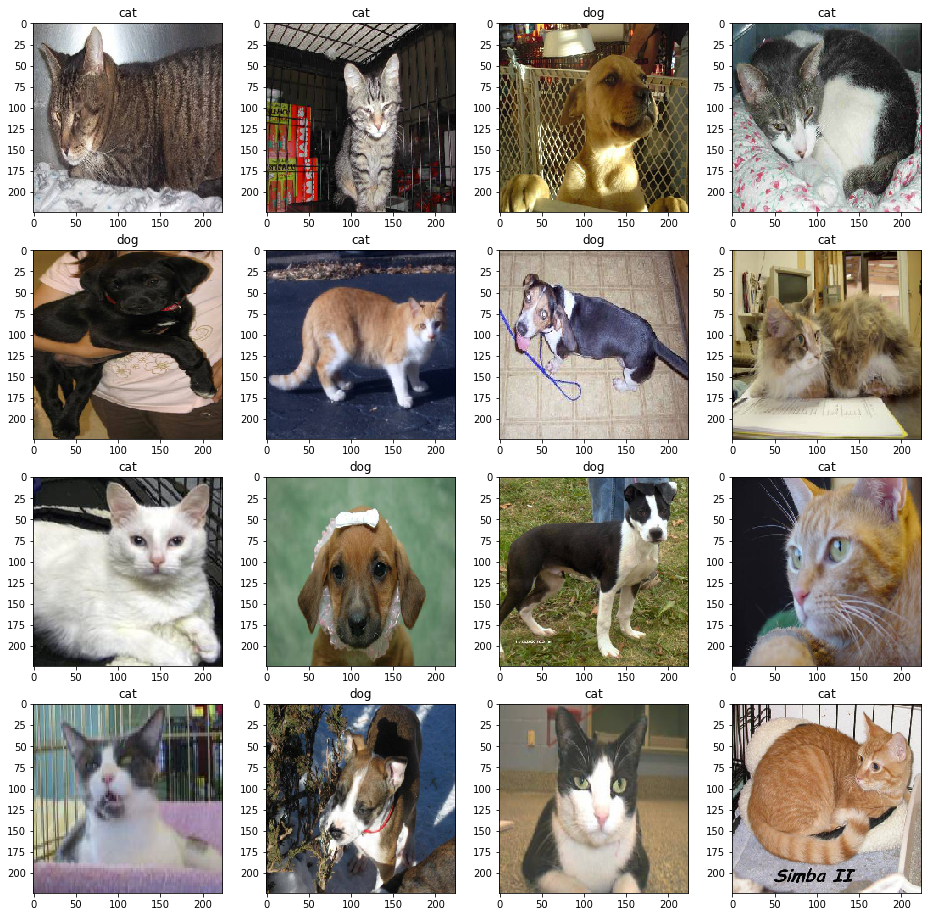

In [5]:
import matplotlib.pyplot as plt

image_size = (224, 224)

(train_img_generator, test_img_generator) = get_images_generator(image_size)

plt.figure(figsize=(16, 16))
for i in list(range(16)):
    (img, label) = train_img_generator.next()
    img = img/255.0
    plt.subplot(4, 4, i+1)
    if label == 1:
        plt.title('dog') 
    else:
        plt.title('cat')
    plt.imshow(img[0,:,:,:], interpolation="nearest")

In [6]:
from keras.models import *
from keras.layers import *
from keras.applications import *

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)

    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    (train_img_generator, test_img_generator) = get_images_generator(image_size)
    
    train = model.predict_generator(train_img_generator, train_img_generator.samples)
    test = model.predict_generator(test_img_generator, test_img_generator.samples)
    
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_img_generator.classes)

Using TensorFlow backend.


In [7]:
# write_gap(ResNet50, (224, 224))
# write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
# write_gap(Xception, (299, 299), xception.preprocess_input)

In [21]:
import h5py
from sklearn.utils import shuffle
np.random.seed(20)

def train_func(optimizer_name="adam", model_list=["gap_ResNet50.h5"]):
    X_train = []
    X_test = []
    
    for filename in model_list:
        with h5py.File(filename, 'r') as h:
            X_train.append(np.array(h['train']))
            X_test.append(np.array(h['test']))
            y_train = np.array(h['label'])

    X_train = np.concatenate(X_train, axis=1)
    X_test = np.concatenate(X_test, axis=1)

    X_train, y_train = shuffle(X_train, y_train)
    
    input_tensor = Input(X_train.shape[1:])
    x = Dropout(0.5)(input_tensor)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, x)

    model.compile(optimizer=optimizer_name,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    train_history = model.fit(X_train, y_train, batch_size=128, nb_epoch=16, validation_split=0.2)
    
    return model, train_history, X_test
    

In [22]:
model_list = []
train_history_list = []
opt_list = ["adadelta","adam","sgd"]
X_test = []

for opt in opt_list:
    model, train_history, test_data = train_func(opt, ["gap_ResNet50.h5"])
    model_list.append(model)
    train_history_list.append(train_history)
    X_test = test_data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 20000 samples, validate on 5000 samples
Epoch 1/16
20000/20000 [==============================] - 1s 44us/step - loss: 0.2907 - acc: 0.8754 - val_loss: 0.1165 - val_acc: 0.9608
Epoch 2/16
20000/20000 [==============================] - 1s 38us/step - loss: 0.1297 - acc: 0.9502 - val_loss: 0.0854 - val_acc: 0.9696
Epoch 3/16
20000/20000 [==============================] - 1s 36us/step - loss: 0.0978 - acc: 0.9642 - val_loss: 0.0734 - val_acc: 0.9722
Epoch 4/16
20000/20000 [==============================] - 1s 37us/step - loss: 0.0892 - acc: 0.9665 - val_loss: 0.0683 - val_acc: 0.9740
Epoch 5/16
20000/20000 [==============================] - 1s 36us/step - loss: 0.0801 - acc: 0.9699 - val_loss: 0.0662 - val_acc: 0.9744
Epoch 6/16
20000/20000 [==============================] - 1s 37us/step - loss: 0.0779 - acc: 0.9701 - val_loss: 0.0638 - val_acc: 0.9754
Epoch 7/16
20000/20000 [==============================] - 1s 37us/step - loss: 0.0756 - acc: 0.9701 - val_loss: 0.0651 - val_acc:

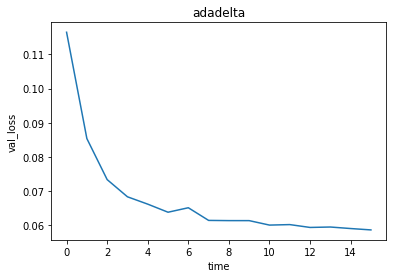

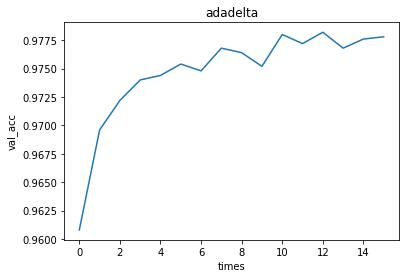

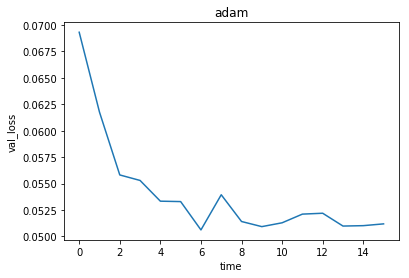

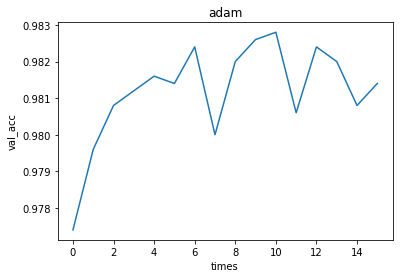

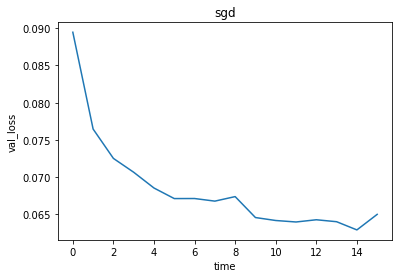

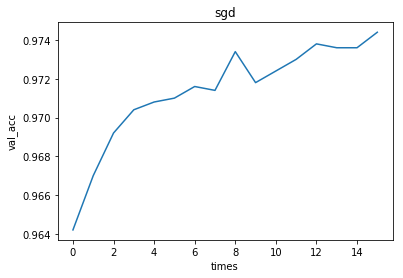

In [23]:
for i, train_history in enumerate(train_history_list):
    plt.plot(train_history.history['val_loss'])
    plt.xlabel('time')
    plt.ylabel('val_loss')
    plt.title(opt_list[i])
    plt.show()

    plt.plot(train_history.history['val_acc'])
    plt.xlabel('times')
    plt.ylabel('val_acc')
    plt.title(opt_list[i])
    plt.show()

In [9]:
model_list = []
train_history_list = []
opt_list = ["adadelta","adam","sgd"]
X_test = []

for opt in opt_list:
    model, train_history, test_data = train_func(opt)
    model_list.append(model)
    train_history_list.append(train_history)
    X_test = test_data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 20000 samples, validate on 5000 samples
Epoch 1/16
20000/20000 [==============================] - 1s 71us/step - loss: 0.1313 - acc: 0.9575 - val_loss: 0.0383 - val_acc: 0.9902
Epoch 2/16
20000/20000 [==============================] - 1s 44us/step - loss: 0.0315 - acc: 0.9914 - val_loss: 0.0262 - val_acc: 0.9924
Epoch 3/16
20000/20000 [==============================] - 1s 45us/step - loss: 0.0224 - acc: 0.9934 - val_loss: 0.0249 - val_acc: 0.9924
Epoch 4/16
20000/20000 [==============================] - 1s 45us/step - loss: 0.0178 - acc: 0.9946 - val_loss: 0.0211 - val_acc: 0.9936
Epoch 5/16
20000/20000 [==============================] - 1s 45us/step - loss: 0.0165 - acc: 0.9944 - val_loss: 0.0208 - val_acc: 0.9938
Epoch 6/16
20000/20000 [==============================] - 1s 45us/step - loss: 0.0152 - acc: 0.9953 - val_loss: 0.0217 - val_acc: 0.9920
Epoch 7/16
20000/20000 [==============================] - 1s 45us/step - loss: 0.0146 - acc: 0.9951 - val_loss: 0.0221 - val_acc:

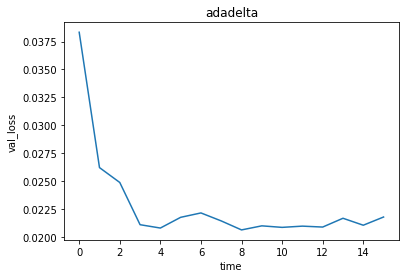

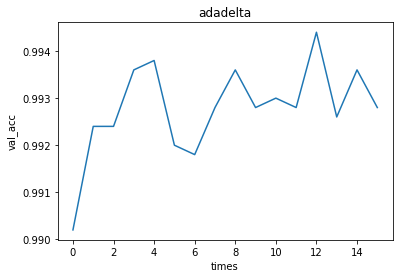

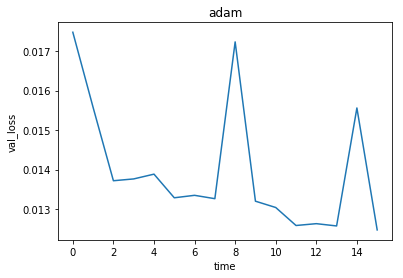

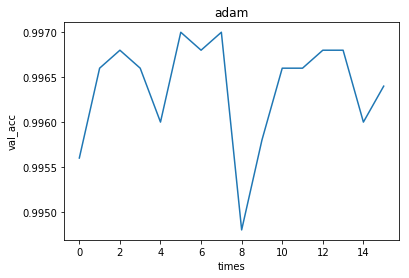

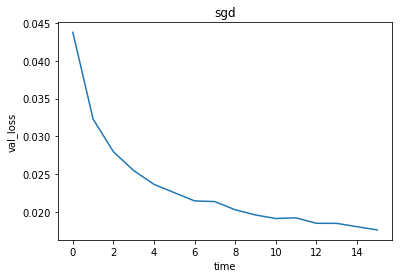

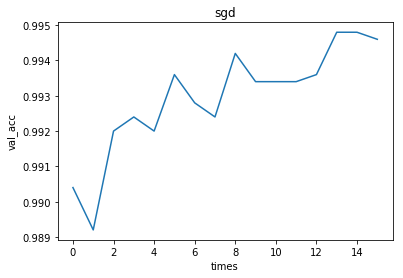

In [15]:
for i, train_history in enumerate(train_history_list):
    plt.plot(train_history.history['val_loss'])
    plt.xlabel('time')
    plt.ylabel('val_loss')
    plt.title(opt_list[i])
    plt.show()

    plt.plot(train_history.history['val_acc'])
    plt.xlabel('times')
    plt.ylabel('val_acc')
    plt.title(opt_list[i])
    plt.show()


In [11]:
# create kaggle file
def generate_kaggle_file(pred_array,file_name):
    df = pd.read_csv("sample_submission.csv")
    df["label"] = pred_array
    print(file_name)
    df.to_csv('submission_{}.csv'.format(file_name), index=None)

In [12]:
opt_list = ["adadelta","adam","sgd"]
for i, model in enumerate(model_list):
    y_pred = model.predict(X_test, verbose=1)
    y_pred = y_pred.clip(min=0.005, max=0.995)
    generate_kaggle_file(y_pred,opt_list[i])

12500/12500 [==============================] - 1s 49us/step
adadelta
12500/12500 [==============================] - 1s 48us/step
adam
12500/12500 [==============================] - 1s 48us/step
sgd


12500/12500 [==============================] - 1s 46us/step


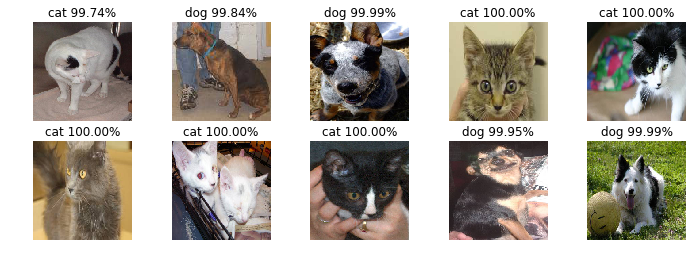

In [14]:
import random
import cv2


prediction = model_list[0].predict(X_test, verbose=1)

img_list = []

for i in list(range(12500)):
    img_list.append(test_img_generator.next())

plt.figure(figsize=(12, 4))

for i in range(10):
    x = random.randint(1, 12500)
    pred = prediction[x]
    
    img = img_list[x]/255.0

    plt.subplot(2, 5, i+1)
    
    if pred < 0.5:
        
        plt.title("cat {:.2f}%".format(100 - float(pred)*100))
    else:
        plt.title("dog {:.2f}%".format(float(pred)*100))
    
    plt.axis('off')
    plt.imshow(img[0,:,:,:], interpolation="nearest")
